In [17]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.io.wavfile as spwav
#from mpldatacursor import datacursor
from IPython.display import Audio
import sys

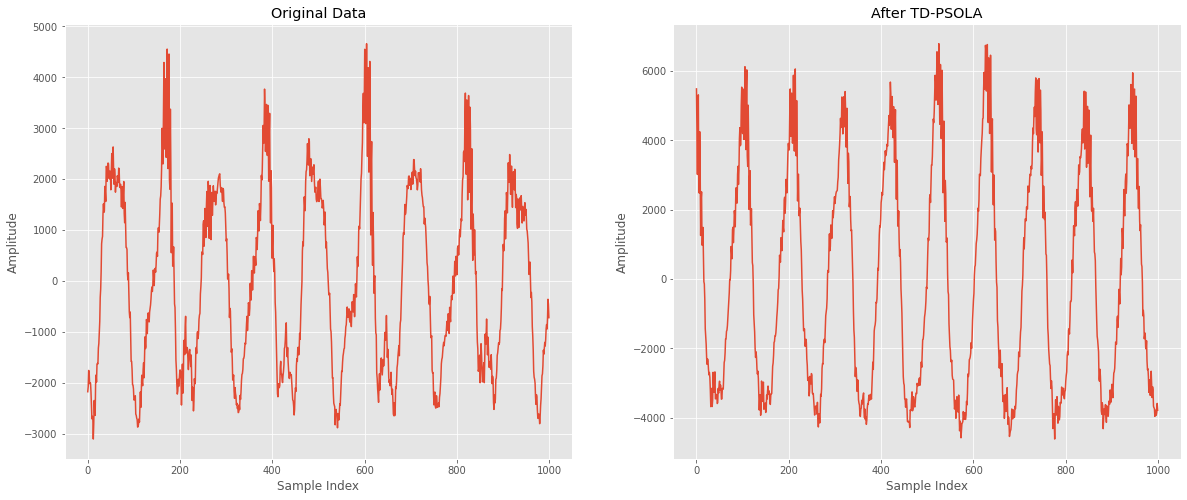

In [22]:
plt.style.use('ggplot')

# Note: this epoch list only holds for "test_vector_all_voiced.wav"
epoch_marks_orig = np.load("test_vector_all_voiced_epochs.npy")
F_s, audio_data = spwav.read("test_vector_all_voiced.wav")
N = len(audio_data)

######################## YOUR CODE HERE ##############################

F_new = 420
new_epoch_spacing = int(F_s / F_new)
# new_epochs = np.arange(new_epoch_spacing, len(audio_data), new_epoch_spacing)

audio_out = np.zeros(N)

# print(epoch_marks_orig)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(audio_data[:1000])
plt.title("Original Data")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
# plt.scatter(epoch_marks_orig[:50], audio_data[epoch_marks_orig[:50]], c='blue')

# Suggested loop
curr_epoch = 0 # idx of epoch in original epoch array, not idx of epoch in original data
new_epoch = 0
for i in range(0, N, new_epoch_spacing):

    # https://courses.engr.illinois.edu/ece420/lab5/lab/#overlap-add-algorithm
    # Your OLA code here
    
    curr_epoch_idx = 0 # corresponds to the original epoch's sample idx in the original audio data
    new_epoch = curr_epoch # assume the epoch we work with next iteration is the same as the current epoch

    # determine based on distance if we need to map to a new epoch
    if curr_epoch + 1 < len(epoch_marks_orig):
        # check which original epoch we want to map to the new epoch
        first_epoch_idx = epoch_marks_orig[curr_epoch]
        second_epoch_idx = epoch_marks_orig[curr_epoch]
        if abs(first_epoch_idx - i) <= abs(second_epoch_idx - i):
            curr_epoch_idx = first_epoch_idx
        else:
            new_epoch += 1 # want to advance the current original epoch
    else:
        # can't advance epochs anymore so just use the last one
        curr_epoch_idx = epoch_marks_orig[curr_epoch]
    
    left_epoch_idx = 0
    right_epoch_idx = 0
    # calculate P0 for current original epoch
    if curr_epoch == 0:
        left_epoch_idx = 0
    else:
        left_epoch_idx = epoch_marks_orig[curr_epoch - 1]
    
    if curr_epoch == len(epoch_marks_orig)-1:
        right_epoch_idx = len(audio_data)-1
    else:
        right_epoch_idx = epoch_marks_orig[curr_epoch + 1]

    p0 = int((right_epoch_idx - left_epoch_idx) / 2)

    # create hanning window to be applied to original epoch
    window_len = int(2*p0 + 1)
    window = [0.5*(1 - np.cos((2*np.pi*l) / window_len)) for l in range(window_len)]

    # apply window to original epoch and add its result around the new epoch location
    for j in range(2*p0 + 1):
        windowed_idx = j # index into window
        audio_data_idx = (curr_epoch_idx - p0) + j # data to use centered around original epoch
        audio_out_idx = (i - p0) + j # location to add windowed data centered around new epoch
        # only sum overlapped data if indices are valid
        if audio_out_idx < len(audio_out) and audio_data_idx < len(audio_data):
            audio_out[audio_out_idx] += window[windowed_idx] * audio_data[audio_data_idx]

    # update the new original epoch we are working with 
    curr_epoch = new_epoch

plt.subplot(122)
plt.plot(audio_out[:1000])
plt.title("After TD-PSOLA")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
# plt.scatter(epoch_marks_orig[:50], audio_out[epoch_marks_orig[:50]], c='blue')
plt.show()

In [19]:
Audio(audio_data, rate=F_s)

In [20]:
Audio(audio_out, rate=F_s)